## Yahoo Finance

In [1]:
import yfinance as yf
import time
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium import webdriver
import chromedriver_binary
import string
import datetime
from forex_python.converter import CurrencyRates
pd.options.display.float_format = '{:.3f}'.format
import matplotlib.pyplot as plt

### Functions for screener results and getting data

In [2]:

def get_rate(from_currency, to_currency, dt):
    date_string = dt.split(" ")
    date_string[1] = date_string[1][:-1]
    date_string = date_string[1] + "-" + date_string[0] + "-" + date_string[2]
    curr_rates = CurrencyRates()
    return curr_rates.get_rate(from_currency.upper(), to_currency.upper(), datetime.datetime.strptime(date_string, "%d-%b-%Y"))


In [34]:
"""
function for scraping screener results which takes two parameters url and currency,
so that we can reuse it for different countries screener 
"""
def get_company_price_data(company_symbol, period = ""):
    driver = webdriver.Chrome()
    #driver.implicitly_wait(5)
    driver.get("https://finance.yahoo.com/quote/{company_symbol}/history?p={company_symbol}".format(company_symbol = company_symbol.upper()))
    try:
        driver.find_element_by_name("agree").click()
    except:
        print("no cookies pop up")
        
    #time.sleep(1)         #in case we need to make the program wait
    if period != "":
        driver.find_element_by_css_selector(".dateRangeBtn").click()
        period_selector = driver.find_element_by_xpath("//button[@data-value='{period}']".format(period = period))
        
        period_selector.click()
        driver.find_element_by_css_selector("#mrt-node-Col1-1-HistoricalDataTable button").click()
        
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0,document.documentElement.scrollHeight);")
        time.sleep(1) 
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height 
        
    html = driver.execute_script('return document.body.innerHTML;')
    soup = BeautifulSoup(html,'html.parser')
    results = soup.find('table').find_all('tr')
    companies_results = []
    for tr in results:
        if len(tr.find_all("td")) >= 5:
            value = float(tr.find_all('td')[4].find('span').text)
            date = tr.find_all('td')[0].find('span').text
            companies_results.append({"date":date, "value_local":value})
            
    return companies_results

    
"""
Function for getting the currency values for all the dates required.
"""

def get_currency_price(from_currency, to_currency, companies, old_data = []):
    data = old_data.copy()
    flag = "add"
    if old_data == []:
        for obj in companies:
            try:
                rate = get_rate(from_currency, to_currency, obj["date"])
                data.append({'date': obj["date"], 'currency_rate': rate})
            except:
                print("missing date:", obj["date"], " error")
                
    else:
        i = 0
        for dicti in companies:
            for dictj in old_data:
                if dicti["date"] == dictj["date"]:
                    flag = "don't add"
            if flag == "add":
                try:
                    rate = get_rate(from_currency, to_currency, dicti["date"])
                    data.insert(i, {'date': dicti["date"], 'currency_rate': rate})
                except:
                    print("missing date:", dicti["date"], " error")
            i += 1        
            flag = "add"
    return data



In [38]:
akbnk = get_company_price_data("akbnk.is", period = "3_M")
print(len(akbnk))



65


In [28]:
turkishLira = get_currency_price("USD", "TRY", akbnk, turkishLira)

print(turkishLira)
print(len(turkishLira))


missing date: Jul 06, 2021  error
missing date: Jun 09, 2021  error
missing date: Apr 08, 2021  error
missing date: Apr 05, 2021  error
missing date: Apr 02, 2021  error
missing date: Mar 30, 2021  error
missing date: Mar 29, 2021  error
missing date: Mar 18, 2021  error
[{'date': 'Jan 28, 2022', 'currency_rate': 13.595259472077574}, {'date': 'Jan 27, 2022', 'currency_rate': 13.615232974910393}, {'date': 'Jan 26, 2022', 'currency_rate': 13.556530992285182}, {'date': 'Jan 25, 2022', 'currency_rate': 13.553691870784522}, {'date': 'Jan 24, 2022', 'currency_rate': 13.413039631988676}, {'date': 'Jan 21, 2022', 'currency_rate': 13.414698625308425}, {'date': 'Jan 20, 2022', 'currency_rate': 13.414535191391781}, {'date': 'Jan 19, 2022', 'currency_rate': 13.592507712648743}, {'date': 'Jan 18, 2022', 'currency_rate': 13.587314155010116}, {'date': 'Jan 17, 2022', 'currency_rate': 13.396211523283347}, {'date': 'Jan 14, 2022', 'currency_rate': 13.563029614746222}, {'date': 'Jan 13, 2022', 'currency

In [20]:
turkishLira_df = pd.DataFrame(data = turkishLira)

turkishLira_df = turkishLira_df.reindex(index = turkishLira_df.index[::-1])

turkishLira_df = turkishLira_df.reset_index(drop = True)

turkishLira_df.dtypes



date              object
currency_rate    float64
dtype: object

In [21]:
turkishLira_df

,date,currency_rate
0,"Jul 30, 2021",8.408
1,"Aug 02, 2021",8.344
2,"Aug 03, 2021",8.378
3,"Aug 04, 2021",8.441
4,"Aug 05, 2021",8.536
...,...,...
124,"Jan 24, 2022",13.413
125,"Jan 25, 2022",13.554
126,"Jan 26, 2022",13.557
127,"Jan 27, 2022",13.615


In [22]:
akbnk_df = pd.DataFrame(data = akbnk)

akbnk_df = akbnk_df.reindex(index = akbnk_df.index[::-1])

akbnk_df = akbnk_df.reset_index(drop = True)

akbnk_df.dtypes


date            object
value_local    float64
dtype: object

In [23]:
akbnk_df.tail(15)

,date,value_local
114,"Jan 10, 2022",7.580
115,"Jan 11, 2022",7.610
116,"Jan 12, 2022",7.630
117,"Jan 13, 2022",7.560
118,"Jan 14, 2022",7.510
119,"Jan 17, 2022",7.750
120,"Jan 18, 2022",7.410
121,"Jan 19, 2022",7.880
122,"Jan 20, 2022",7.840
123,"Jan 21, 2022",7.920


In [24]:
merged_df = pd.merge(turkishLira_df, akbnk_df, how = "inner", on = ["date"])
merged_df["value_usd"] = merged_df["value_local"] / merged_df["currency_rate"]
merged_df

,date,currency_rate,value_local,value_usd
0,"Jul 30, 2021",8.408,5.260,0.626
1,"Aug 02, 2021",8.344,5.300,0.635
2,"Aug 03, 2021",8.378,5.350,0.639
3,"Aug 04, 2021",8.441,5.420,0.642
4,"Aug 05, 2021",8.536,5.520,0.647
...,...,...,...,...
124,"Jan 24, 2022",13.413,7.580,0.565
125,"Jan 25, 2022",13.554,7.700,0.568
126,"Jan 26, 2022",13.557,7.700,0.568
127,"Jan 27, 2022",13.615,7.760,0.570


## Plot

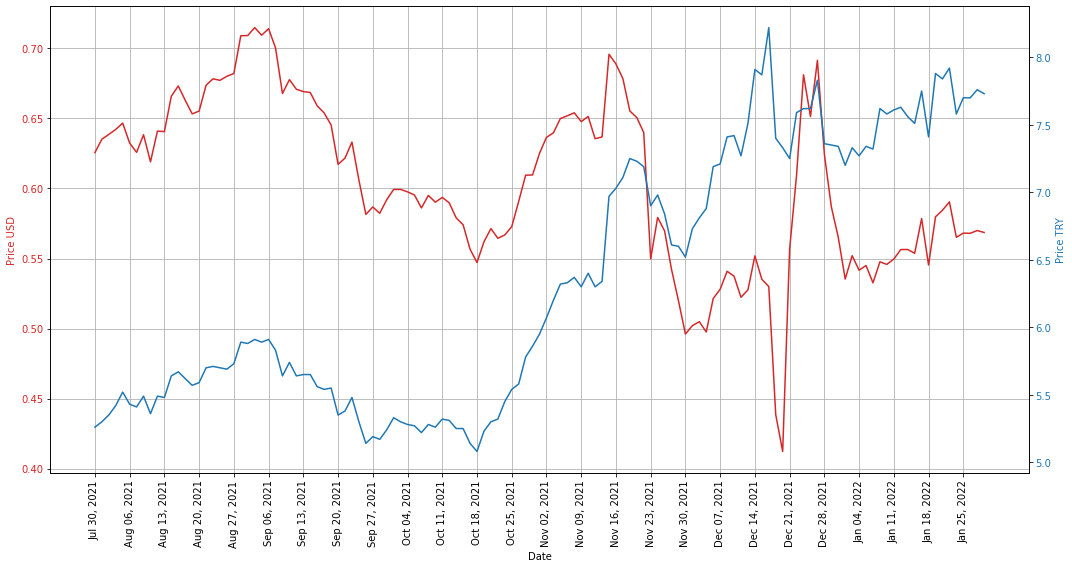

In [25]:
# set figure, size and xtick rotation before setting axis
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.xticks(rotation=90)

# first axis for the first plot
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price USD', color=color)
ax1.plot(merged_df['date'], merged_df['value_usd'], color = color)
ax1.tick_params(axis='y', labelcolor=color)

# second axis for the second plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Price TRY', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_df['date'], merged_df['value_local'], color = color)
ax2.tick_params(axis='y', labelcolor=color)

# set X ticks frequency for both plot x axis
if len(merged_df['date']) < 500:
    x_ticks_frequency = merged_df['date'][::5]
    ax1.set_xticks(x_ticks_frequency)
    ax2.set_xticks(x_ticks_frequency)
    
if len(merged_df['date']) > 500:
    x_ticks_frequency = merged_df['date'][::25]
    ax1.set_xticks(x_ticks_frequency)
    ax2.set_xticks(x_ticks_frequency)

# show plot
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(which = "both", axis = "both")
#ax2.grid(which = "both", axis = "both")
plt.show()